In [ ]:
import numpy as np
import os
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader,random_split
from PIL import Image
import torch.nn as nn
from torch.optim import Adam, AdamW
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
import matplotlib.pyplot as plt
import cv2
from net import UNet
from utils import sample_and_infer, compute_metrics
from dataset import OCTDataset
!pip install torchmetrics
!pip install lpips
import lpips
from torchmetrics.image import StructuralSimilarityIndexMeasure as SSIM

In [ ]:
torch.cuda.empty_cache()
import gc
gc.collect()

60

### Define Global Variables

In [4]:
EPOCHS = 50
BATCH_SIZE = 2
LR = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

In [ ]:
model = UNet().to(DEVICE)
criterion = nn.MSELoss()
ssim = SSIM(data_range=2.0).to(DEVICE)
#criterion = nn.L1Loss() #mod
#criterion = CombinedLoss(alpha=0.8)  # Try alpha=0.8, but tune it if needed
optimizer = Adam(model.parameters(), lr=LR)
#optimizer = AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=5, verbose=True) #mod
#scheduler = StepLR(optimizer, step_size=10, gamma=0.3)
# Load dataset
data_dir = "/content/drive/MyDrive/dataset_tesi"
dataset = OCTDataset(data_dir)

# Split into train and validation sets (80% train, 20% validation)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


### Training Loop

In [ ]:
train_losses = []
val_losses = []
val_ssims = []
best_val_loss = float("inf")
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Training]", leave=False):
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

        outputs = model(inputs)
        loss = criterion(outputs, targets)*100

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0
    val_ssim = 0
    with torch.no_grad():
        for inputs, targets in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Validation]", leave=False):
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, targets)*100
            ssim_value = ssim(outputs.to(DEVICE),targets.to(DEVICE))
            val_loss += loss.item()
            val_ssim += ssim_value.item()

    val_ssim /= len(val_loader)
    val_ssims.append(val_ssim)
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {train_loss:.6f} - Val Loss: {val_loss:.6f} - LR: {scheduler.get_last_lr()[0]:.6f}")

    if val_loss < best_val_loss:
        print("New best model found!")
        best_val_loss = val_loss
        torch.save(model.state_dict(), "/content/drive/MyDrive/saves_from_training/models/best_unet_dict.pth")
        torch.save(model, "/content/drive/MyDrive/saves_from_training/models/best_unet.pth")
        print("Best model saved!")

    scheduler.step(val_loss)


### Model Testing

In [ ]:
model = torch.load("/content/drive/MyDrive/saves_from_training/models/best_unet.pth", weights_only=False).to(DEVICE)
model.eval()

Make inference with 2 random sample

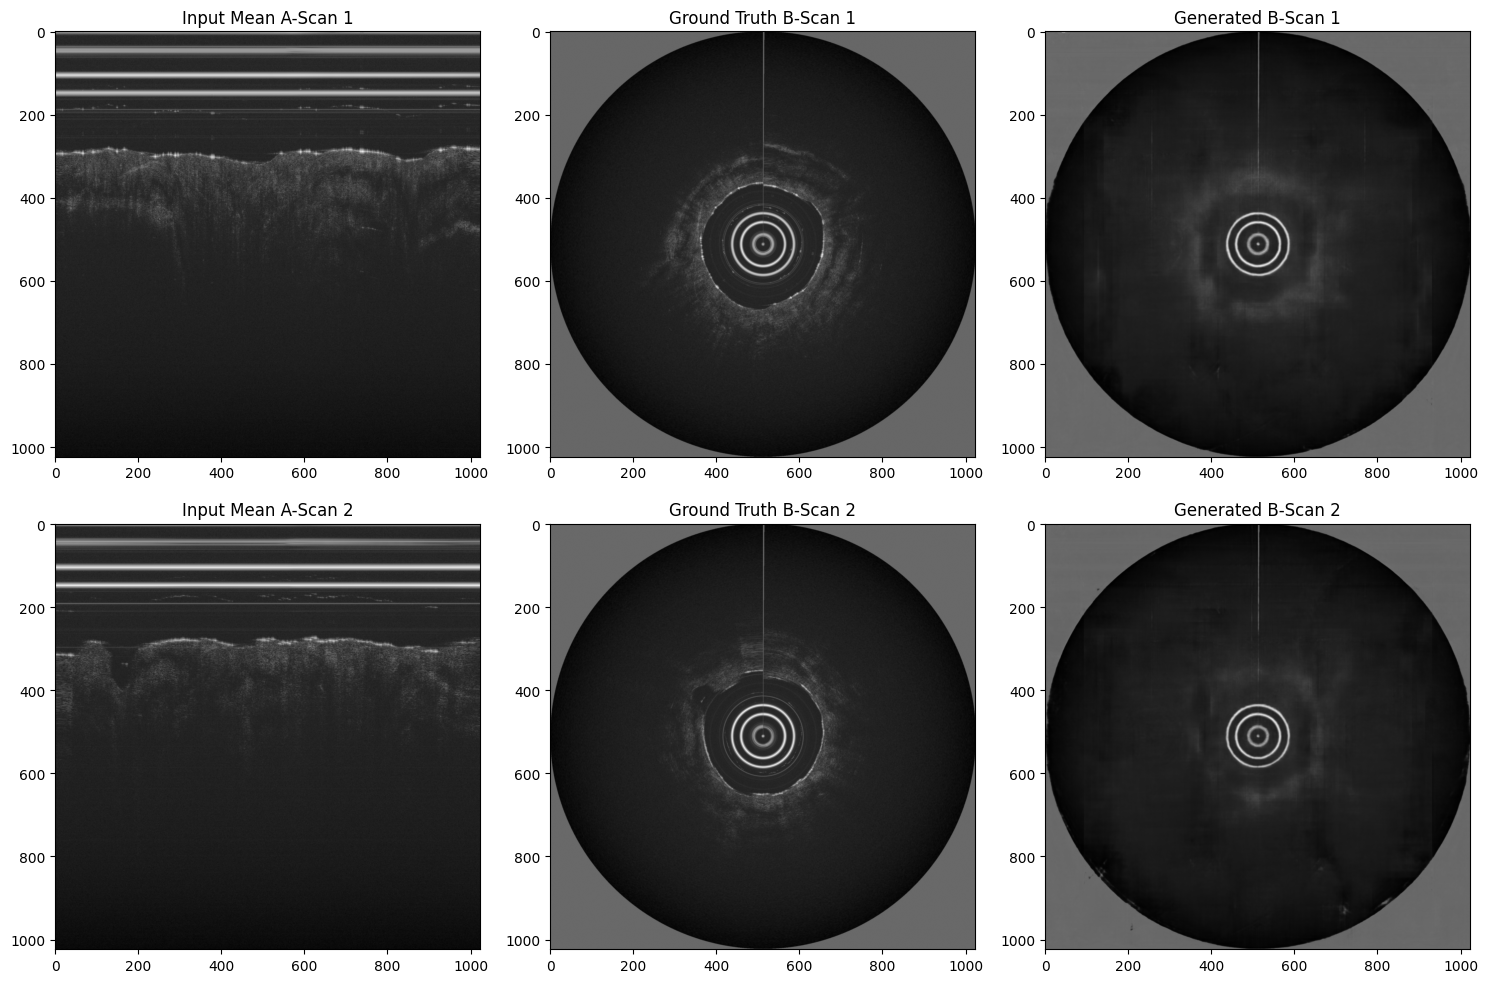

In [ ]:
sample_and_infer(model, dataset, DEVICE)

### Plots about losses and metrics

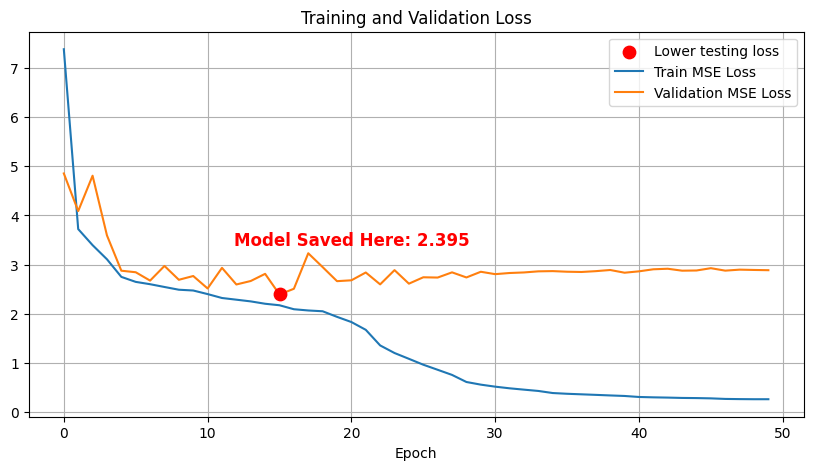

In [ ]:
# prompt: #plot val_loss, train_loss and val_ssim
min_testing_loss_epoch = np.argmin(val_losses)
min_testing_loss_value = val_losses[min_testing_loss_epoch]

plt.figure(figsize=(10, 5))
plt.scatter(min_testing_loss_epoch,min_testing_loss_value, color="red", s=80, zorder=3, label="Lower testing loss")
plt.text(min_testing_loss_epoch+5,min_testing_loss_value+1, f"Model Saved Here: {min_testing_loss_value:.3f}",
         fontsize=12, color="red", ha="center", fontweight="bold")
plt.plot(train_losses, label='Train MSE Loss')
plt.plot(val_losses, label='Validation MSE Loss')
plt.xlabel('Epoch')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


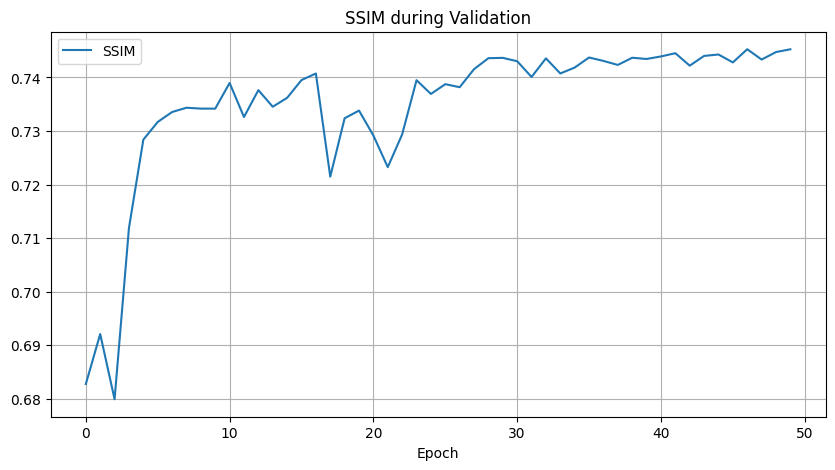

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(val_ssims , label='SSIM', color = "purple",linewidth=2, alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('SSIM')
plt.title('Test SSIM', fontsize=14, fontweight="bold")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


Model evaluation on 2 metrics

In [ ]:
#Metrics computation
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

lpips_loss = lpips.LPIPS(net='vgg').to(DEVICE)  # Use a VGG-based perceptual metric
ssim = SSIM(data_range=2.0).to(DEVICE)
#gen = UNet().to(DEVICE)
#gen.load_state_dict(torch.load("/content/drive/MyDrive/saves_from_training/models/bestbest_unet_dict.pth", weights_only=True))

_, val_dataset = random_split(dataset, [0.8,0.2])
len_data = len(val_dataset)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
compute_metrics(model, val_loader, lpips_loss, ssim, len_data, DEVICE)

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/vgg.pth


Computing SSIM and LPIPS: 100%|██████████| 166/166 [00:18<00:00,  9.09it/s]

SSIM Value is: 0.843
LPIPS Value is: 0.528
